#  Can we make a hit movie ?
This project aims to understand the descriptions of top n movies and create our very own movie. We also explore different methods of predicting if a movie will stink or be a hit in the box office by using various parameters. So basically,
1. Make our very own movie 
2. Predict if a movie will be a hit based on Cast, Genre etc.
3. Determine if we can accurately predict using the movie descriptions
4. Compare our made-up movie with our predictions

So, Let's begin shall we ?

## Step 1: Find our data

*We obtained our dataset from https://www.kaggle.com/datasets/rounakbanik/the-movies-dataset?select=ratings.csv*

lets import it and view what data it contains

*The first cell contains all the imports you'll need for this project. Make sure you run this first*

In [29]:
import pandas as pd 
import numpy as np 
import keras.utils as ku 
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer
from keras.layers import Embedding, LSTM, Dense, Dropout
from keras.models import Sequential

import warnings
warnings.filterwarnings("ignore")
warnings.simplefilter(action='ignore', category=FutureWarning)


In [30]:
df1=pd.read_csv('./movies_metadata.csv')
df1.head(1)

,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,...,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count
0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",...,1995-10-30,373554033.0,81.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Toy Story,False,7.7,5415.0


Our data looks usable, now we need to perform a little cleanup to keep only the data that is relevant to us

So, that brings us to -

## Step 2: Feature Cleaning

Let us drop all the fields that we will not require. Like the IMDB links, Status, Tagline. These features in no way relate to our final output. We can use our common sense to eliminate them.

Some of them, we are not too sure. Take the "runtime" column. A higher runtime may mean a lesser rating. Maybe or Maybe not. But, we cannot eliminate by just using common sense.


In [31]:
# Drop all unneccesary fields
df1.drop(["id","belongs_to_collection","homepage","imdb_id","revenue","spoken_languages","status","tagline","original_title","video","popularity","poster_path","production_companies","production_countries"],axis=1,inplace=True)
# Drop all NULL,None,NA values
df1.dropna()
# Drop all the values where vote average is 0
df1 = df1.replace(0, np.nan).dropna(axis=0, how='any', subset=["vote_count","overview"])
df1

,adult,budget,genres,original_language,overview,release_date,runtime,title,vote_average,vote_count
0,False,30000000,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",en,"Led by Woody, Andy's toys live happily in his ...",1995-10-30,81.0,Toy Story,7.7,5415.0
1,False,65000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",en,When siblings Judy and Peter discover an encha...,1995-12-15,104.0,Jumanji,6.9,2413.0
2,False,0,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...",en,A family wedding reignites the ancient feud be...,1995-12-22,101.0,Grumpier Old Men,6.5,92.0
3,False,16000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",en,"Cheated on, mistreated and stepped on, the wom...",1995-12-22,127.0,Waiting to Exhale,6.1,34.0
4,False,0,"[{'id': 35, 'name': 'Comedy'}]",en,Just when George Banks has recovered from his ...,1995-02-10,106.0,Father of the Bride Part II,5.7,173.0
...,...,...,...,...,...,...,...,...,...,...
45459,False,0,"[{'id': 878, 'name': 'Science Fiction'}]",en,It's the year 3000 AD. The world's most danger...,1995-01-01,85.0,Caged Heat 3000,3.5,1.0
45460,False,0,"[{'id': 18, 'name': 'Drama'}, {'id': 28, 'name...",en,"Yet another version of the classic epic, with ...",1991-05-13,104.0,Robin Hood,5.7,26.0
45461,False,0,"[{'id': 18, 'name': 'Drama'}, {'id': 10751, 'n...",fa,Rising and falling between a man and woman.,NaN,90.0,Subdue,4.0,1.0
45462,False,0,"[{'id': 18, 'name': 'Drama'}]",tl,An artist struggles to finish his work while a...,2011-11-17,360.0,Century of Birthing,9.0,3.0


Our data looks clean enough. However, we cannot use some of the features as is. We need to manipulate this into a more usable form. This is called as Feature Engineering

## Step 3: Feature Engineering

Let us take a look at vote_average and vote_count. One user rating a movie very highly versus 100 users voting a movie very highly has a huge difference, so we need to apply a formula to even this out.

First, let us visualise the data and see for ourselves

<Axes: xlabel='vote_average'>

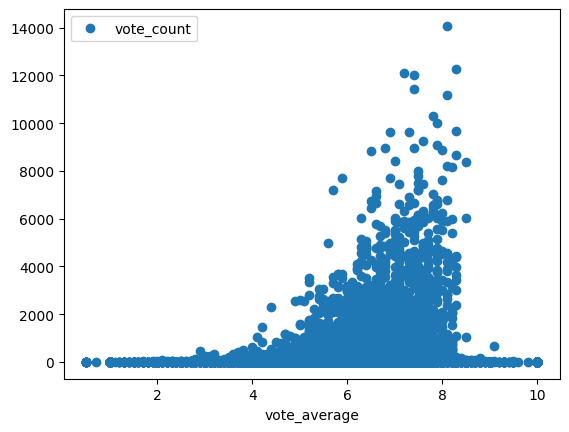

In [32]:
df1.plot(x='vote_average', y='vote_count', style='o')

We can see a lot of votes are being cast by less amount of people. That is why we need a cutoff of the amount of votes and then calculate a weighted average.

Let us set a threshold value "t". We have chosen 1000 votes


(1121, 10)

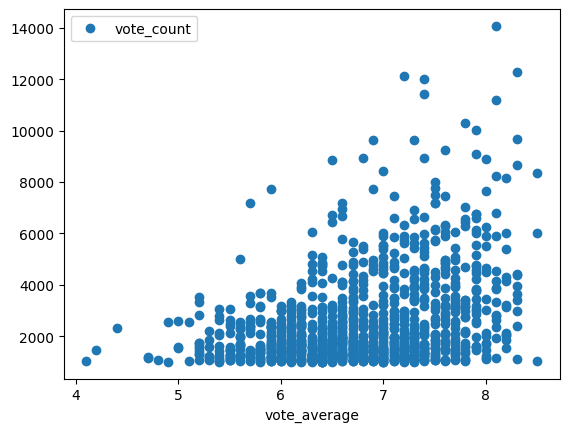

In [33]:
t = 1000
C= df1['vote_average'].mean()
movies = df1.copy().loc[df1['vote_count'] >= t]
movies.plot(x='vote_average', y='vote_count', style='o')
movies.shape

This Looks much better. Now let us calculate our weighted score

*We got this lovely formula from here: https://www.kaggle.com/code/ibtesama/getting-started-with-a-movie-recommendation-system*

In [34]:

def weighted_rating(x, t=t, C=C):
    v = x['vote_count']
    R = x['vote_average']
    # Calculation based on the IMDB formula
    return (v/(v+t) * R) + (t/(t+v) * C)

movies['score'] = movies.apply(weighted_rating, axis=1)
movies.head(10)



,adult,budget,genres,original_language,overview,release_date,runtime,title,vote_average,vote_count,score
0,False,30000000,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",en,"Led by Woody, Andy's toys live happily in his ...",1995-10-30,81.0,Toy Story,7.7,5415.0,7.437627
1,False,65000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",en,When siblings Judy and Peter discover an encha...,1995-12-15,104.0,Jumanji,6.9,2413.0,6.641248
5,False,60000000,"[{'id': 28, 'name': 'Action'}, {'id': 80, 'nam...",en,"Obsessive master thief, Neil McCauley leads a ...",1995-12-15,170.0,Heat,7.7,1886.0,7.116798
9,False,58000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 28, '...",en,James Bond must unmask the mysterious head of ...,1995-11-16,130.0,GoldenEye,6.6,1194.0,6.334220
15,False,52000000,"[{'id': 18, 'name': 'Drama'}, {'id': 80, 'name...",en,The life of the gambling paradise – Las Vegas ...,1995-11-22,178.0,Casino,7.8,1343.0,7.038958
18,False,30000000,"[{'id': 80, 'name': 'Crime'}, {'id': 35, 'name...",en,"Summoned from an ashram in Tibet, Ace finds hi...",1995-11-10,90.0,Ace Ventura: When Nature Calls,6.1,1128.0,6.060939
31,False,29500000,"[{'id': 878, 'name': 'Science Fiction'}, {'id'...",en,"In the year 2035, convict James Cole reluctant...",1995-12-29,129.0,Twelve Monkeys,7.4,2470.0,7.001406
46,False,33000000,"[{'id': 80, 'name': 'Crime'}, {'id': 9648, 'na...",en,Two homicide detectives are on a desperate hun...,1995-09-22,127.0,Se7en,8.1,5915.0,7.798753
47,False,55000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 16, '...",en,History comes gloriously to life in Disney's e...,1995-06-14,81.0,Pocahontas,6.7,1509.0,6.427732
49,False,6000000,"[{'id': 18, 'name': 'Drama'}, {'id': 80, 'name...",en,"Held in an L.A. interrogation room, Verbal Kin...",1995-07-19,106.0,The Usual Suspects,8.1,3334.0,7.619354


This looks much better. Now let us sort it and obtain the top `top` number of movies.

In [36]:
top = 300
movies = movies.sort_values('score', ascending=False)
top_movies = movies.head(top)
top_movies.head(5)

,adult,budget,genres,original_language,overview,release_date,runtime,title,vote_average,vote_count,score
314,False,25000000,"[{'id': 18, 'name': 'Drama'}, {'id': 80, 'name...",en,Framed in the 1940s for the double murder of h...,1994-09-23,142.0,The Shawshank Redemption,8.5,8358.0,8.234653
834,False,6000000,"[{'id': 18, 'name': 'Drama'}, {'id': 80, 'name...",en,"Spanning the years 1945 to 1955, a chronicle o...",1972-03-14,175.0,The Godfather,8.5,6024.0,8.146480
12481,False,185000000,"[{'id': 18, 'name': 'Drama'}, {'id': 28, 'name...",en,Batman raises the stakes in his war on crime. ...,2008-07-16,152.0,The Dark Knight,8.3,12269.0,8.127936
2843,False,63000000,"[{'id': 18, 'name': 'Drama'}]",en,A ticking-time-bomb insomniac and a slippery s...,1999-10-15,139.0,Fight Club,8.3,9678.0,8.086185
292,False,8000000,"[{'id': 53, 'name': 'Thriller'}, {'id': 80, 'n...",en,"A burger-loving hit man, his philosophical par...",1994-09-10,154.0,Pulp Fiction,8.3,8670.0,8.063896


Shawshank Redemption is at first place. Seems like the formula worked afterall. 

What. A. Masterpiece.

Now, let us write some code to cleanup the "Genre" section

In [37]:
import ast
def splitGenres(x):
    biglist = []
    x = ast.literal_eval(x)
    for elem in x:
        biglist.append(elem["name"])
    return biglist
movies["genres"] = movies["genres"].apply(splitGenres)
top_movies["genres"] = top_movies["genres"].apply(splitGenres)
movies.head(1)

,adult,budget,genres,original_language,overview,release_date,runtime,title,vote_average,vote_count,score
314,False,25000000,"[Drama, Crime]",en,Framed in the 1940s for the double murder of h...,1994-09-23,142.0,The Shawshank Redemption,8.5,8358.0,8.234653


In [38]:
g_movies = movies.explode("genres")
g_movies.head(1)

,adult,budget,genres,original_language,overview,release_date,runtime,title,vote_average,vote_count,score
314,False,25000000,Drama,en,Framed in the 1940s for the double murder of h...,1994-09-23,142.0,The Shawshank Redemption,8.5,8358.0,8.234653


<Axes: xlabel='genres'>

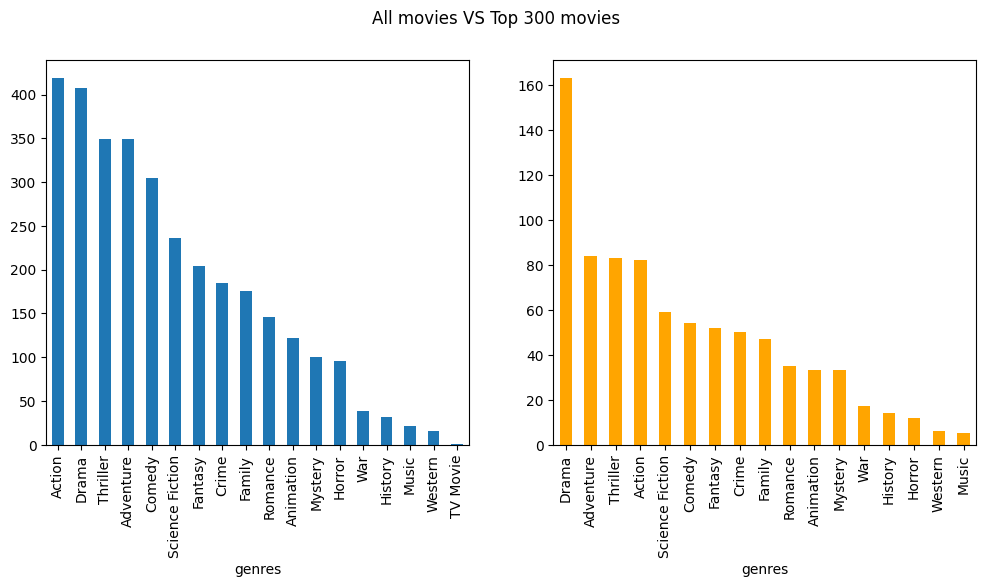

In [66]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 2, figsize=(12, 5))
fig.suptitle('All movies VS Top ' + str(top) + ' movies')

top_movies = top_movies.explode("genres")

g_movies.genres.value_counts().plot(kind='bar', ax=axs[0])
top_movies.genres.value_counts().plot(kind='bar',ax=axs[1], color = "orange")

We can clearly see that, although more Action movies have been made; it seems that Drama movies are more popular. 

With all this out of the way. Let us now start our first task. Making up our very own movie.

# Making our movie

The idea is to extract all the descriptions of the top N movies. And then to use this to train our model. 

What exactly can we use ?

## the answer is L.S.T.M (Long Short-Term Memory)

It is a RNN that we can use for sequence prediction. This akin to your phone predicting what word comes after you type another word.



In [59]:

#longpath problem
all_descriptions = list(movies.overview.values)
len(all_descriptions)

1121

In [60]:
corpus = [x for x in all_descriptions]
corpus = corpus[0:300]


In [61]:
t = Tokenizer(num_words=None, filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n', lower=True, split=' ', char_level=False, oov_token=None, document_count=0)
t.fit_on_texts(corpus)
print(t.word_counts)
print(t.word_docs)
print(t.document_count)
print(t.word_index)
print('Found %s unique tokens.' % len(t.word_index))

OrderedDict([('framed', 1), ('in', 288), ('the', 891), ('1940s', 2), ('for', 97), ('double', 1), ('murder', 3), ('of', 452), ('his', 304), ('wife', 16), ('and', 479), ('her', 90), ('lover', 3), ('upstanding', 1), ('banker', 3), ('andy', 4), ('dufresne', 2), ('begins', 16), ('a', 622), ('new', 38), ('life', 69), ('at', 67), ('shawshank', 1), ('prison', 6), ('where', 29), ('he', 138), ('puts', 1), ('accounting', 1), ('skills', 5), ('to', 479), ('work', 7), ('an', 116), ('amoral', 1), ('warden', 1), ('during', 18), ('long', 5), ('stretch', 2), ('comes', 8), ('be', 46), ('admired', 2), ('by', 85), ('other', 18), ('inmates', 1), ('including', 3), ('older', 7), ('prisoner', 2), ('named', 18), ('red', 2), ('integrity', 1), ('unquenchable', 1), ('sense', 2), ('hope', 6), ('spanning', 2), ('years', 26), ('1945', 3), ('1955', 3), ('chronicle', 1), ('fictional', 1), ('italian', 2), ('american', 14), ('corleone', 5), ('crime', 11), ('family', 39), ('when', 70), ('organized', 1), ('patriarch', 1), 

In [62]:
# Tokenization
t = Tokenizer(num_words=None, filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n', lower=True, split=' ', char_level=False, oov_token=None, document_count=0)

def get_sequence_of_tokens(corpus):
    t.fit_on_texts(corpus)
    total_words = len(t.word_index) + 1
    
    input_sequences = []
    for line in corpus:
        token_list = t.texts_to_sequences([line])[0]
        for i in range(1, len(token_list)):
            n_gram_sequence = token_list[:i+1]
            input_sequences.append(n_gram_sequence)
            
    return input_sequences, total_words
input_sequences, total_words = get_sequence_of_tokens(corpus)
input_sequences[:10]

[[1657, 7],
 [1657, 7, 1],
 [1657, 7, 1, 927],
 [1657, 7, 1, 927, 15],
 [1657, 7, 1, 927, 15, 1],
 [1657, 7, 1, 927, 15, 1, 1658],
 [1657, 7, 1, 927, 15, 1, 1658, 587],
 [1657, 7, 1, 927, 15, 1, 1658, 587, 5],
 [1657, 7, 1, 927, 15, 1, 1658, 587, 5, 6],
 [1657, 7, 1, 927, 15, 1, 1658, 587, 5, 6, 84]]

In [63]:
# pad sequences 
def generate_padded_sequences(input_sequences):
    max_sequence_len = max([len(x) for x in input_sequences])
    input_sequences = np.array(pad_sequences(input_sequences, maxlen = max_sequence_len, padding = 'pre'))
    predictors, label = input_sequences[:,:-1],input_sequences[:,-1]
    label = ku.to_categorical(label, num_classes = total_words)
    
    return predictors, label, max_sequence_len

predictors, label, max_sequence_len = generate_padded_sequences(input_sequences)

In [64]:
def create_model(max_sequence_len, total_words):
    model = Sequential()
    
    # Add Input Embedding Layer
    model.add(Embedding(total_words, 10, input_length=max_sequence_len - 1))
    
    # Add Hidden Layer 1 - LSTM Layer
    model.add(LSTM(100))
    model.add(Dropout(0.1))
    
    # Add Output Layer
    model.add(Dense(total_words, activation='softmax'))

    model.compile(loss='categorical_crossentropy', optimizer='adam')
    
    return model

model = create_model(max_sequence_len, total_words)
model.summary()

model.fit(predictors, label, epochs=50, verbose=5)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 173, 10)           44360     
                                                                 
 lstm_2 (LSTM)               (None, 100)               44400     
                                                                 
 dropout_2 (Dropout)         (None, 100)               0         
                                                                 
 dense_2 (Dense)             (None, 4436)              448036    
                                                                 
Total params: 536796 (2.05 MB)
Trainable params: 536796 (2.05 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/50
Epoch 2/50
Epoch 3/50
Epoch 4/50
Epoch 5/50
Epoch 6/50
Epoch 7/50
Epoch 8/50
Epoch 9/50
Epoch 10/50
Epoch 11/50
Epoch 12/50
Epoch 13/50
Epo

In [65]:
def generate_text(seed_text, next_words, model, max_seq_len):
    for _ in range(next_words):
        token_list = t.texts_to_sequences([seed_text])[0]
        token_list = pad_sequences([token_list], maxlen=max_seq_len-1, padding='pre')
        
        #predicted = model.predict_classes(token_list, verbose=0)
        predict_x=model.predict(token_list, verbose=0) 
        classes_x=np.argmax(predict_x,axis=1)
        
        output_word = ''
        
        for word,index in t.word_index.items():
            if index == classes_x:
                output_word = word
                break
                
        seed_text = seed_text + " " + output_word
        
    return seed_text.title()

In [66]:
print(generate_text("The", 100, model, max_sequence_len))

The True Story Of Katherine G Johnson Dorothy Vaughan And Mary Jackson – Brilliant African American Women Working At Nasa And A Violent Tower And Roam The Uncharted Areas Of Space The Greatest Wanted And Memories And Bloodshed Countrywide When The Alien Is Inhabited To Be Us Down The Man Is Being Captain Left Him To Escape And The Peaceful And Fascinating Experiment And Destroyed Him Nearly Killing Killing Prepares The Eyes Of The Chaos And Furiosa The Unlikely And Nearly Despite To Be Them And The Peaceful Man Community Has Eight Away To End His Entire Skills And Serve To
